In [150]:
# Imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [151]:
# Set up initial variables such as S{0, 1, 2}, T{1, 2} and their deltas.

meter = 1
year = 365 * 24 * 3600
S0 = 35.0
T0 = 24.0
rho0 = 1
S1, S2 = 12, 20
T1, T2 = 1, 11
DeltaT = T1 - T2
DeltaS = S1 - S2
time_max = 10000 * year
alpha = 0.2 # (kg/m^3) K^-1
beta = 0.8 # (kg/m^3) ppt^-1
k = 10e9 # (m^3/s)/(kg/m^3) # 3e-8; # sec^-1
# area of each of the ocean boxes, rediculous value, needed to get
# all other results at the right order of magnitude:
area = (50000.0e3) ** 2
depth = 4000
V = area * depth # volume of each of the ocean boxes
Sv = 1.e9 # m^3/sec

In [152]:
# Formalize the model.
class BoxModel:
    def __init__(self, S0, S1, S2, T1, T2, alpha, beta, k, area, depth):
        self.S0 = S0
        self.S1 = S1
        self.S2 = S2
        self.T1 = T1
        self.T2 = T2
        self.alpha = alpha
        self.beta = beta
        self.k = k
        self.area = area
        self.depth = depth

    @property
    def DeltaT(self):
        return self.T1 - self.T2

    @property
    def DeltaS(self):
        return self.S1 - self.S2

    def q(self, DeltaT, DeltaS):
        """Implements the AMOC volume transport q."""
        # THC transport in m^3/sec as function of temperature and salinity
        # difference between the boxes
        
        rho_1_2_diff = self.alpha * DeltaT - self.beta * DeltaS
        flow = self.k * rho_1_2_diff
        
        return flow

    def d_q_t(self):
        """Implements the analytical derivative of q wrt. t."""
        return -self.k * self.beta * 2 * (self.F - abs(self.q(self.DeltaT, self.DeltaS)) * self.DeltaS)

    def d_DeltaS_t(self, F, DeltaT, DeltaS):
        """Implementation according to Potsdam"""
        return -2 * abs(self.q(DeltaT, DeltaS)) * DeltaS - 2 * F

    def rho(self, T, S):
        return rho0 * (1 - self.alpha * T + self.beta * S)
    
    def steady_states(self, F, X):
        """Implements the steady state solutions of the model."""
        Y = np.zeros((3,))
    
        y1 = (X - np.sqrt(X**2 + 4 * self.beta * F / self.k)) / 2
        val = X**2 - 4 * self.beta * F / self.k
    
        # The argument to the square root function has to be positive.
        if val > 0:
            offset = X / 2
            y2 = offset + np.sqrt(val) / 2
            y3 = offset - np.sqrt(val) / 2
        # Simply set the solution to NaN if the argument is non-positive.
        else:
            y2 = np.nan
            y3 = np.nan
        
        Y = np.array([y1, y2, y3])
        return Y

    def Fs_func(self, time, time_max, is_Fs_time_dependent):
        # total surface salt flux into northern box
        # Specify maximum and minimum of freshwater forcing range during the
        # run in m/year:
        FW_min = -0.1
        FW_max = 5
    
        if is_Fs_time_dependent:
            flux = FW_min + (FW_max - FW_min) * time / time_max
        else:
            flux = 2
    
        # convert to total salt flux:
        return flux * area * S0 / year

    def rhs_S(self, time, time_max, is_Fs_time_dependent, DeltaT=None, DeltaS=None):
        # Input: q in m^3/sec; FW is total salt flux into box
        DeltaT = self.DeltaT if DeltaT is None else DeltaT
        DeltaS = self.DeltaS if DeltaS is None else DeltaS
        
        F_s = self.Fs_func(time, time_max, is_Fs_time_dependent)
        rhs = 2 * (F_s - abs(self.q(DeltaT, DeltaS)) * DeltaS)
        return rhs / V

    def simulate(self, Fs_range):
        # Compute the steady state solutions as well as the q values for the above values of F.
        DeltaS_steady = np.zeros((3, len(Fs_range)))
        q_steady = np.zeros((3, len(Fs_range)))
        
        for i, Fs in enumerate(Fs_range):
            Y = self.steady_states(Fs, self.alpha * self.DeltaT)
            # translate Y solution to a solution for DeltaS:
            DeltaS_steady[:, i] = Y / self.beta
            for j in range(3):
                q_steady[j, i] = self.q(DeltaT, DeltaS_steady[j, i])

        return DeltaS_steady, q_steady

In [153]:
def scale_Fs(Fs, area, S0, year):
    return Fs * area * S0 / year

In [154]:
# Generate some plots.
# This sort of validates the correctness of the implementation since the plots are the same
# as in the textbook.

def plot_steady(Fs_range, DeltaS_steady, q_steady, normalize=True):
    plt.figure(1, figsize=(8, 4), dpi=200)
    Fs_to_m_per_year = S0 * area / year
    
    Fs_range_normalized = np.copy(Fs_range)
    if normalize:
        Fs_range_normalized /= Fs_to_m_per_year
    
    plt.subplot(1, 2, 1)
    # plot all three solutions for Delta S as function of Fs in units of m/year:
    plt.plot(Fs_range_normalized, DeltaS_steady[0, :], 'r.', markersize=1)
    plt.plot(Fs_range_normalized, DeltaS_steady[1, :], 'g.', markersize=1)
    plt.plot(Fs_range_normalized, DeltaS_steady[2, :], 'b.', markersize=1)
    
    # plot a dash think line marking the zero value:
    plt.plot(Fs_range_normalized, np.zeros(DeltaS_steady.shape[1]), 'k--', dashes=(10, 5), linewidth=0.5)
    plt.title('(a) steady states')
    plt.xlabel('$F_s$ (m/year)');
    plt.ylabel('$\Delta S$');
    plt.xlim([min(Fs_range_normalized), max(Fs_range_normalized)])
    
    plt.subplot(1, 2, 2)
    # plot all three solutions for q (in Sv) as function of Fs in units of m/year:
    plt.plot(Fs_range_normalized, q_steady[0, :], 'r.', markersize=1)
    plt.plot(Fs_range_normalized, q_steady[1, :], 'g.', markersize=1)
    plt.plot(Fs_range_normalized, q_steady[2, :], 'b.', markersize=1)
    plt.plot(Fs_range_normalized, np.zeros(q_steady.shape[1]), 'k--', dashes=(10, 5), linewidth=0.5)
    plt.title('(b) steady states')
    plt.xlabel('$F_s$ (m/year)')
    plt.ylabel('$q$ (Sv)')
    plt.tight_layout()

    ls_min_max_1 = [(min(DeltaS_steady[i, :]), max(DeltaS_steady[i, :])) for i in range(3)]
    ls_min_max_2 = [(min(q_steady[i, :]), max(q_steady[i, :])) for i in range(3)]

    return ls_min_max_1, ls_min_max_2

In [155]:
Fs_range = np.arange(0, 5, 0.01)
Fs_range = scale_Fs(Fs_range, area, S0, year)
model = BoxModel(S0, S1, S2, T1, T2, alpha, beta, k, area, depth)
DeltaS_steady, q_steady = model.simulate(Fs_range)

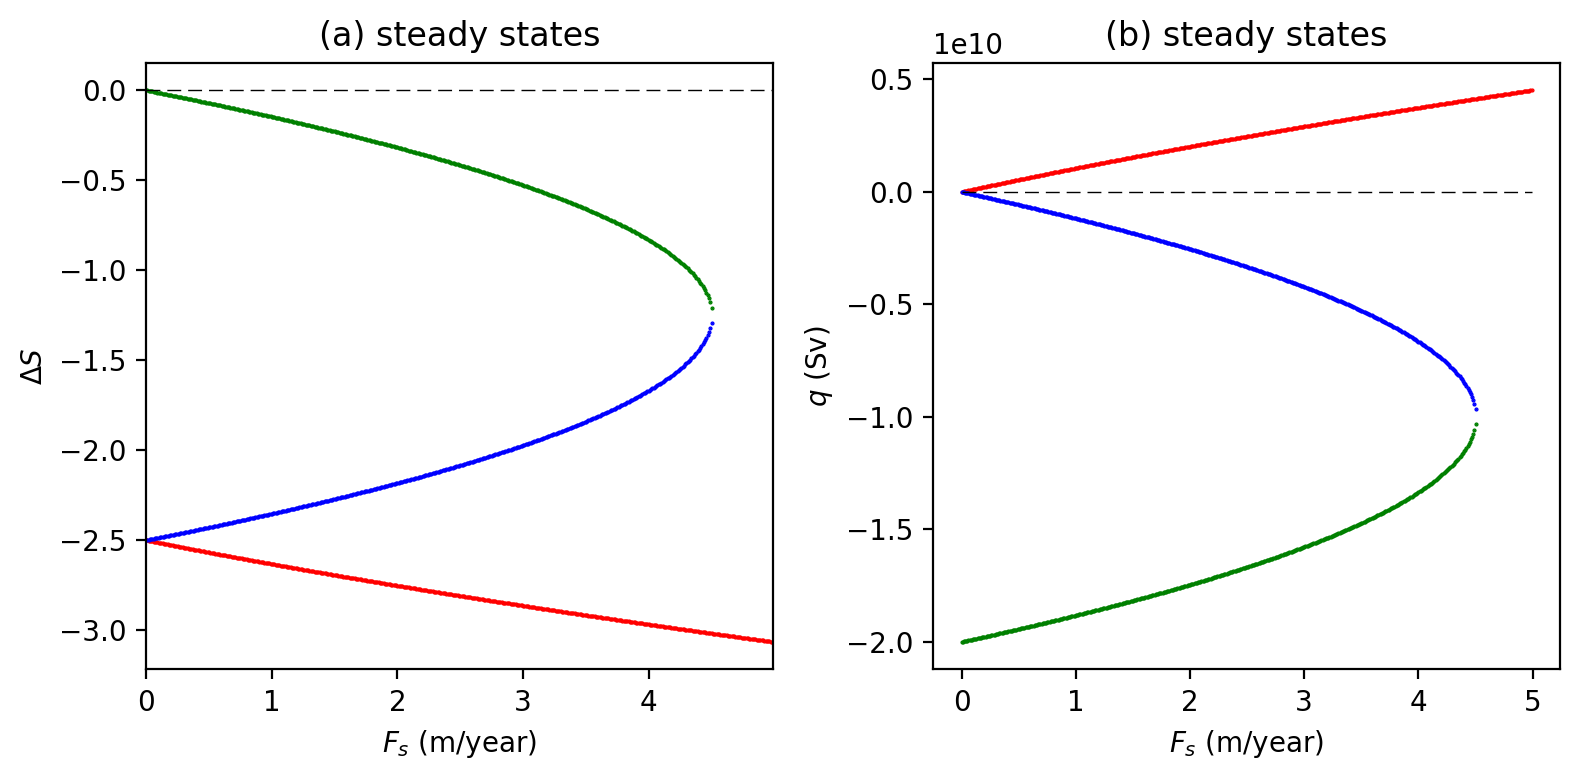

In [156]:
ls_min_max_1, ls_min_max_2 = plot_steady(Fs_range, DeltaS_steady, q_steady)

In [157]:
def F_sinusoidal(x, p):
    return np.sin(p * x)

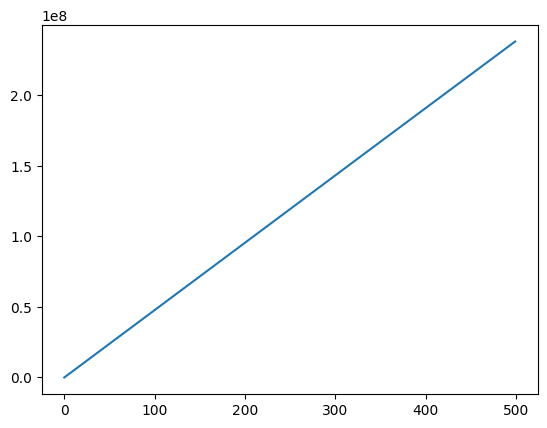

In [181]:
xs = np.arange(0, 5, 0.01)
P = (2 * np.pi) / 365
Fs_sin = F_sinusoidal(xs, P)
Fs_sin = scale_Fs(Fs_sin, area, S0, year)

plt.plot(Fs_sin)

([(-2.511846001550643, -2.5),
  (-0.011959343005790574, 0.0),
  (-2.5, -2.488040656994209)],
 [(0.0, 94768012.40514643),
  (-20000000000.0, -19904325255.953674),
  (-95674744.0463257, 0.0)])

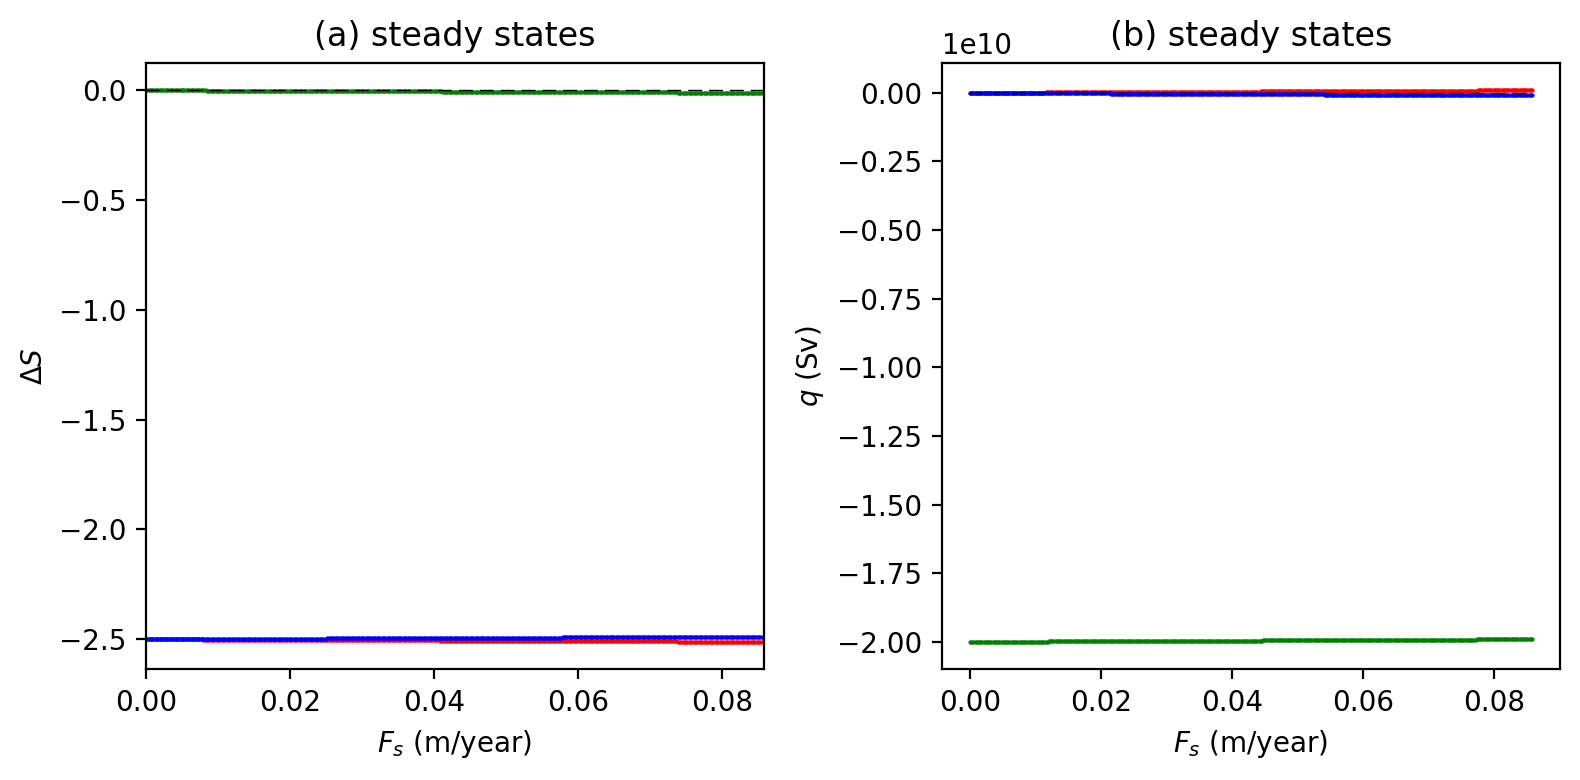

In [179]:
DeltaS_steady_sin, q_steady_sin = model.simulate(Fs_sin)
plot_steady(Fs_sin, DeltaS_steady_sin, q_steady_sin)

([(-3.0647068607942995, -2.5),
  (-1.2077664138500332, 0.0),
  (-2.5, -1.2922335861499663)],
 [(0.0, 4517654886.354397),
  (-20000000000.0, -10337868689.199734),
  (-9662131310.800268, 0.0)])

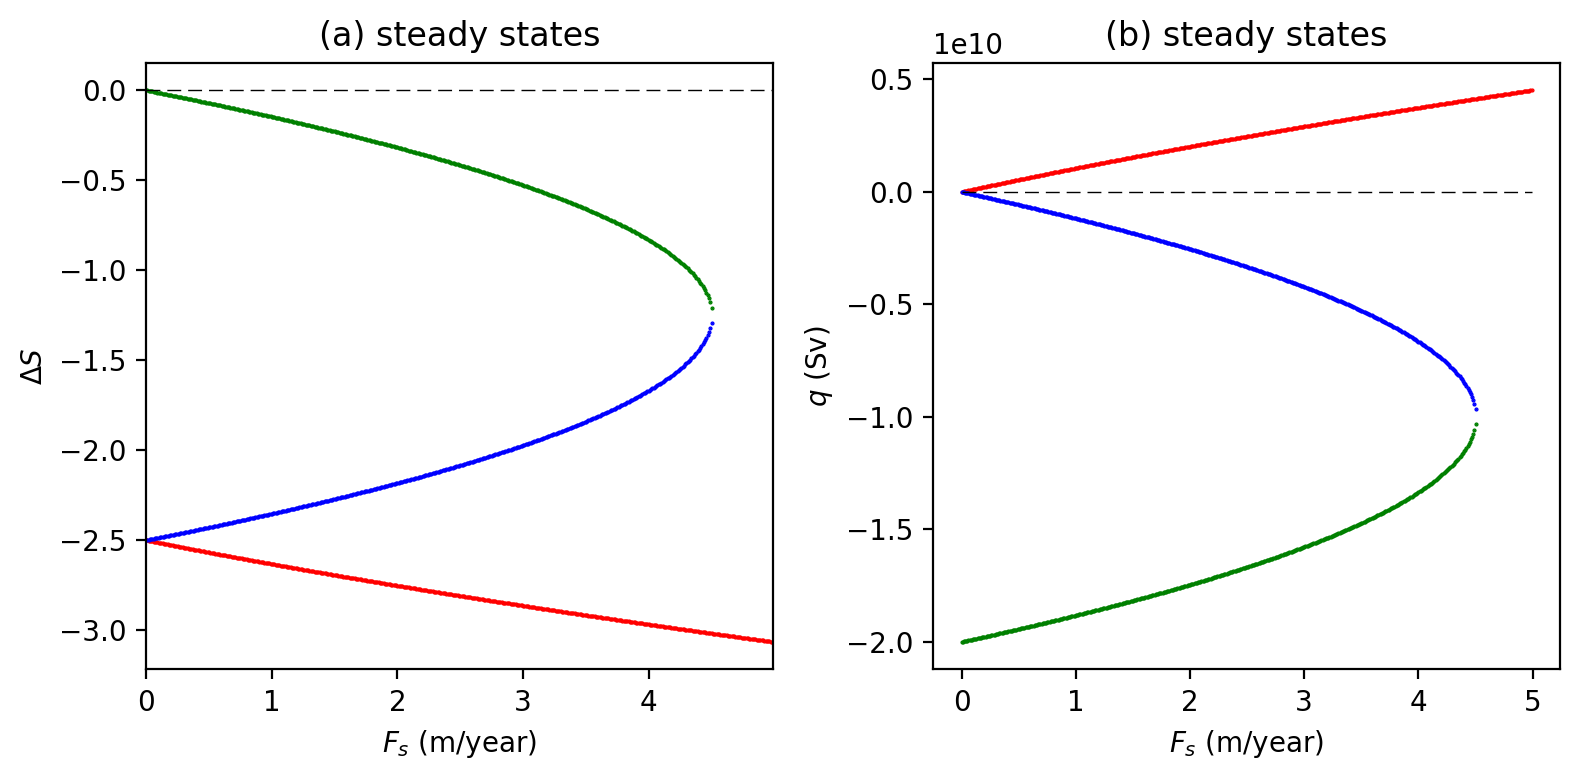

In [160]:
Ts_1 = np.arange(10)
Ts_2 = 2 * Ts_1 + 1

T1, T2 = Ts_1[5], Ts_2[7]
model.T1 = T1
model.T2 = T2

DeltaS_steady, q_steady = model.simulate(Fs_range)
plot_steady(Fs_range, DeltaS_steady, q_steady)

[0.0000000e+00 3.1536000e+08 6.3072000e+08 9.4608000e+08 1.2614400e+09
 1.5768000e+09 1.8921600e+09 2.2075200e+09 2.5228800e+09 2.8382400e+09
 3.1536000e+09 3.4689600e+09 3.7843200e+09 4.0996800e+09 4.4150400e+09
 4.7304000e+09 5.0457600e+09 5.3611200e+09 5.6764800e+09 5.9918400e+09
 6.3072000e+09 6.6225600e+09 6.9379200e+09 7.2532800e+09 7.5686400e+09
 7.8840000e+09 8.1993600e+09 8.5147200e+09 8.8300800e+09 9.1454400e+09
 9.4608000e+09 9.7761600e+09 1.0091520e+10 1.0406880e+10 1.0722240e+10
 1.1037600e+10 1.1352960e+10 1.1668320e+10 1.1983680e+10 1.2299040e+10
 1.2614400e+10 1.2929760e+10 1.3245120e+10 1.3560480e+10 1.3875840e+10
 1.4191200e+10 1.4506560e+10 1.4821920e+10 1.5137280e+10 1.5452640e+10
 1.5768000e+10 1.6083360e+10 1.6398720e+10 1.6714080e+10 1.7029440e+10
 1.7344800e+10 1.7660160e+10 1.7975520e+10 1.8290880e+10 1.8606240e+10
 1.8921600e+10 1.9236960e+10 1.9552320e+10 1.9867680e+10 2.0183040e+10
 2.0498400e+10 2.0813760e+10 2.1129120e+10 2.1444480e+10 2.1759840e+10
 2.207

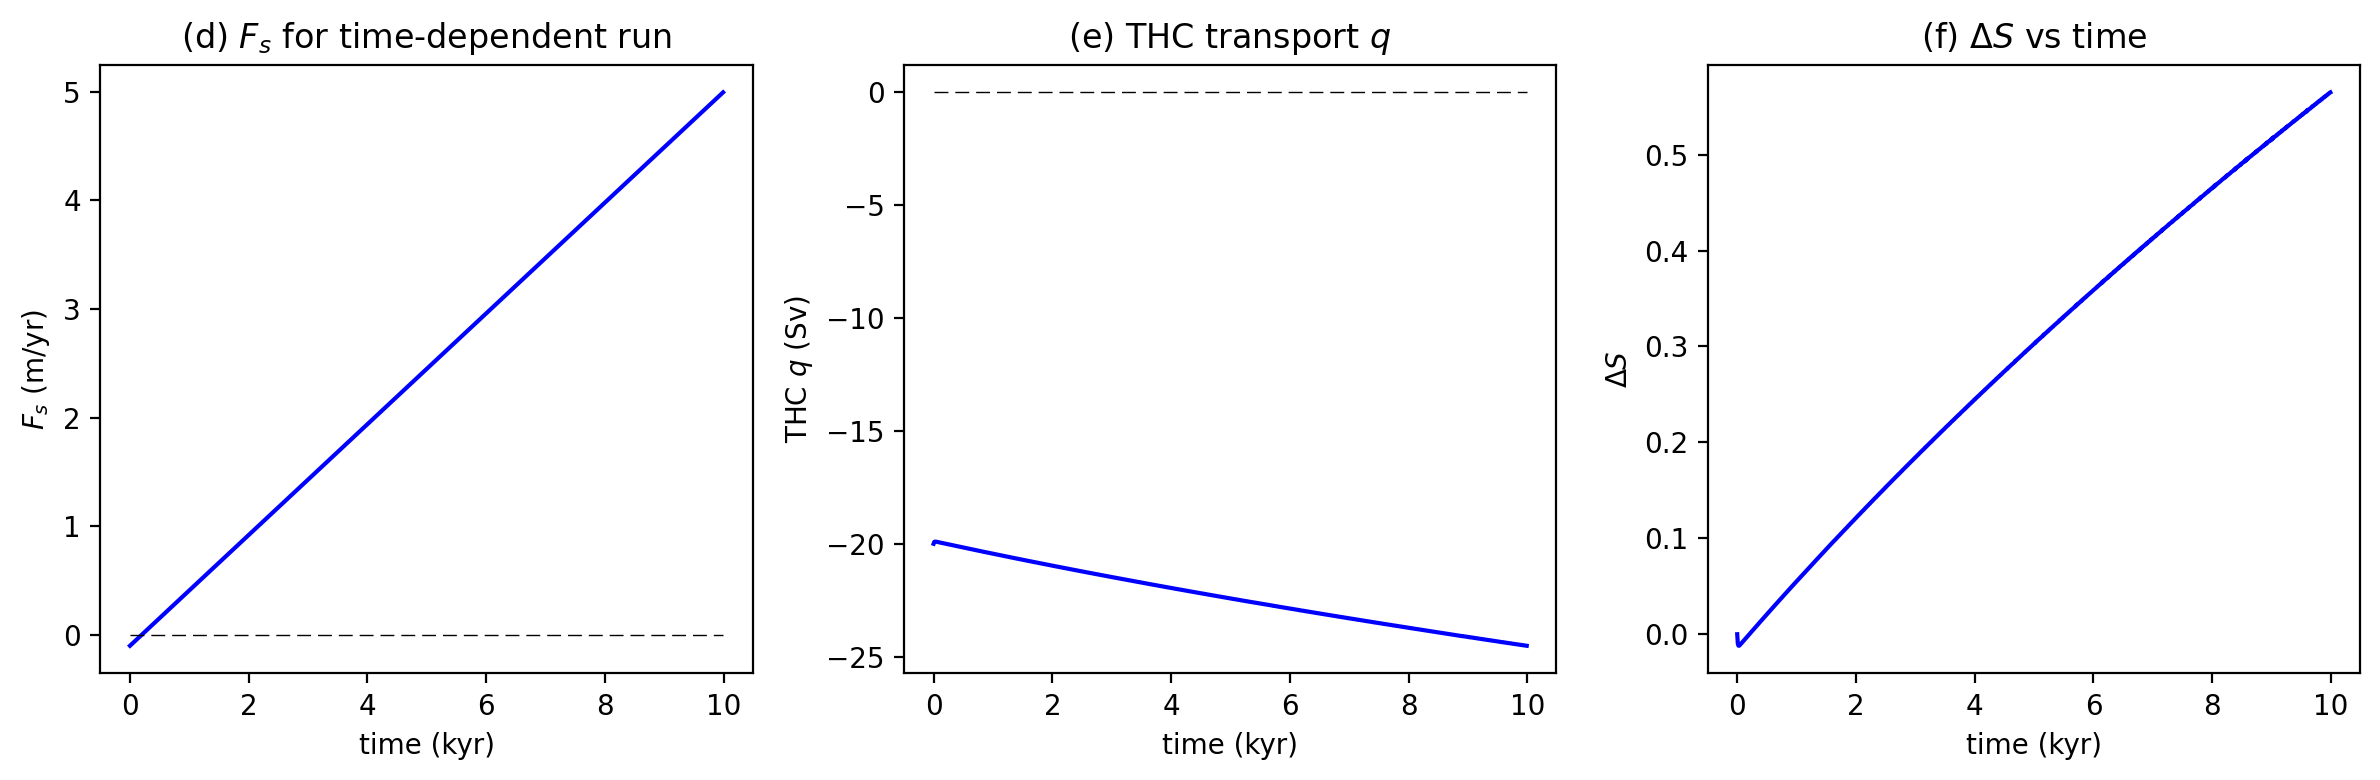

In [182]:
# next, do a time dependent run:
# ------------------------------
is_Fs_time_dependent = True
y0 = [0]
teval = np.arange(0, time_max,time_max / 1000)
tspan = (teval[0], teval[-1])
Fs_to_m_per_year = S0 * area / year
sol = solve_ivp(fun=lambda time, DeltaS: model.rhs_S(time, time_max, is_Fs_time_dependent, DeltaS=DeltaS),
                vectorized=False,
                y0=y0,
                t_span=tspan,
                t_eval=teval)
Time = sol.t
DeltaS = sol.y
print(Time)

is_Fs_time_dependent = True
FWplot = np.zeros(len(Time))
qplot = np.zeros(len(Time))

for i, t in enumerate(Time):
    FWplot[i] = model.Fs_func(t, time_max, is_Fs_time_dependent)
    qplot[i] = model.q(DeltaT, DeltaS[0, i])
    
N = len(qplot)

plt.figure(figsize=(12, 4), dpi=200)
plt.subplot(1, 3, 1)
plt.plot(Time / year / 1000, FWplot / Fs_to_m_per_year, 'b-', markersize=1)
plt.plot(Time / year / 1000, 0 * Time, 'k--', dashes=(10, 5), linewidth=0.5)
plt.xlabel('time (kyr)')
plt.ylabel('$F_s$ (m/yr)')
plt.title('(d) $F_s$ for time-dependent run')

plt.subplot(1, 3, 2)
plt.plot(Time / year / 1000, qplot / Sv, 'b-', markersize=1)
plt.plot(Time / year / 1000, Time * 0, 'k--', dashes=(10, 5), lw=0.5)
plt.xlabel('time (kyr)')
plt.ylabel('THC $q$ (Sv)')
plt.title('(e) THC transport $q$')

plt.subplot(1, 3, 3)
plt.plot(Time / year / 1000, DeltaS[0, :], 'b-', markersize=1)
plt.title('(f) $\Delta S$ vs time')
plt.xlabel('time (kyr)')
plt.ylabel('$\Delta S$')

plt.tight_layout()
plt.show()

Text(0, 0.5, '$d\\Delta S/dt$')

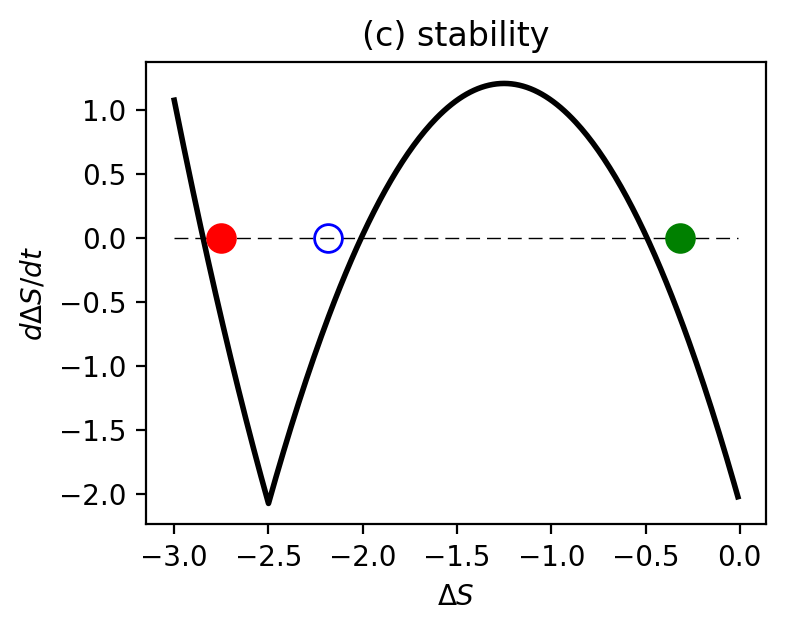

In [185]:
# use fixed (time-independent) value of fresh water forcing for this case:
is_Fs_time_dependent = False
time = 0
DeltaS_range = np.arange(-3, 0, 0.01)
rhs = np.zeros(len(DeltaS_range))

for i in range(len(DeltaS_range)):
    DeltaS = DeltaS_range[i]
    rhs[i] = model.rhs_S(time, time_max, is_Fs_time_dependent, DeltaS=DeltaS)

rhs -= np.mean(rhs)
rhs /= np.std(rhs)

plt.figure(figsize=(4, 3), dpi=200)
plt.plot(DeltaS_range, rhs, 'k-', lw=2)
plt.plot(DeltaS_range, rhs * 0, 'k--', dashes=(10, 5), lw=0.5)

# superimpose color markers of the 3 solutions
Fs = model.Fs_func(0.0, 0.0, False)
yy = model.steady_states(Fs, model.alpha * model.DeltaT) / model.beta

plt.plot(yy[0], 0, 'ro', markersize=10)
plt.plot(yy[1], 0, 'go', markersize=10)
plt.plot(yy[2], 0, 'bo', markersize=10, fillstyle='none')
plt.title('(c) stability')
plt.xlabel('$\Delta S$')
plt.ylabel('$d\Delta S/dt$')

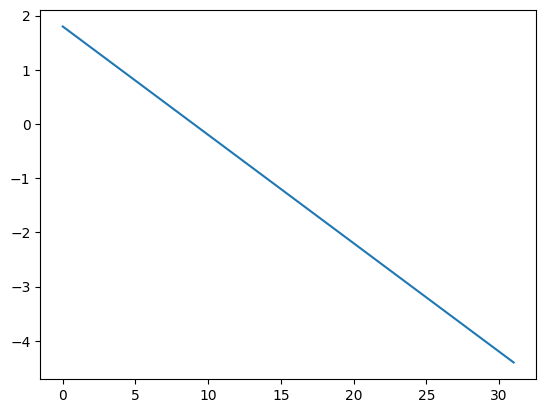

In [163]:
temperatures = np.linspace(0, 31)
rhos = model.rho(temperatures, 1)
plt.plot(temperatures, rhos)

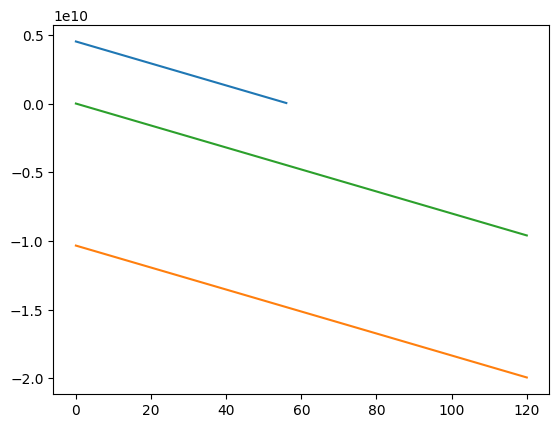

In [164]:
Fs_range2 = np.arange(0, 5, 0.01)
Fs_range2 = scale_Fs(Fs_range2, area, S0, year)

DeltaS_range_r = np.arange(ls_min_max_1[0][0], ls_min_max_1[0][1], 0.01)
DeltaS_range_g = np.arange(ls_min_max_1[1][0], ls_min_max_1[1][1], 0.01)
DeltaS_range_b = np.arange(ls_min_max_1[2][0], ls_min_max_1[2][1], 0.01)

# q_range_r = np.arange(ls_min_max_2[0][0], ls_min_max_2[0][1], 0.01)
# q_range_g = np.arange(ls_min_max_2[1][0], ls_min_max_2[1][1], 0.01)
# q_range_b = np.arange(ls_min_max_2[2][0], ls_min_max_2[2][1], 0.01)

qs_r = [model.q(model.DeltaT, DeltaS) for DeltaS in DeltaS_range_r]
qs_g = [model.q(model.DeltaT, DeltaS) for DeltaS in DeltaS_range_g]
qs_b = [model.q(model.DeltaT, DeltaS) for DeltaS in DeltaS_range_b]

# plt.subplot(1, 2, 1)
plt.plot(qs_r)
plt.plot(qs_g)
plt.plot(qs_b)

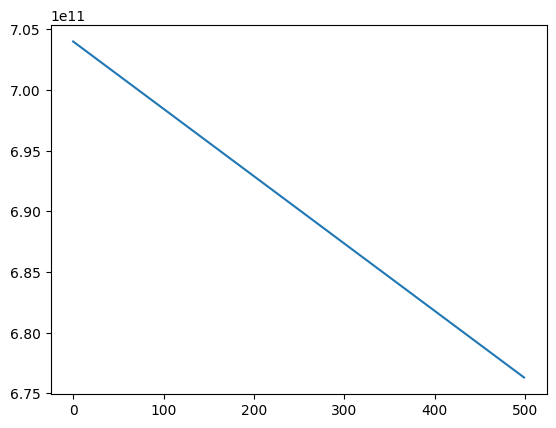

In [165]:
Fs_DeltaS = np.arange(0, 5, 0.01)
Fs_DeltaS = scale_Fs(Fs_DeltaS, area, S0, year)
dS = model.d_DeltaS_t(Fs_DeltaS, model.DeltaT, model.DeltaS)
plt.plot(dS)